# Notebook to develop and test the ABC Rejection on DAP cell model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tqdm import tqdm

from delfi.distribution import Uniform
from dap.utils import obs_params_gbar, syn_current, load_current
from dap.dap_sumstats_step_mom import DAPSummaryStatsStepMoments
from dap import DAPcython
from dap.dap_simulator import DAPSimulator

### General Settings Pick

In [2]:
n_samples = 100
n_summary = 17
dt = 0.1

### Get current

In [3]:
# load the data
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'    # best cell
I, v, t, t_on, t_off, dt = load_current(data_dir, protocol='IV', ramp_amp=1)

# generate syntetic data
params, labels = obs_params_gbar(reduced_model=True)

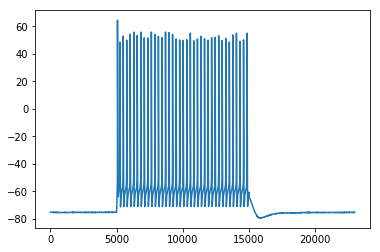

In [4]:
dap = DAPcython(-75, params)
U = dap.simulate(dt, t, I)
plt.plot(U);

### Set up the model

In [5]:
sim = DAPSimulator(I, dt, -75, dim_param=1)
stats = DAPSummaryStatsStepMoments(t_on, t_off, n_summary=n_summary)

### Setup Priors

In [6]:
prior_min = np.array([0])
prior_max = np.array([1])
prior_unif = Uniform(lower=prior_min, upper=prior_max)

In [7]:
params = prior_unif.gen(n_samples=2000)
params

array([[0.95692502],
       [0.72743886],
       [0.23519327],
       ...,
       [0.18385278],
       [0.29958589],
       [0.18860876]])

### generate desired data

In [8]:
U = dap.simulate(dt, t, I)
y_o = {'data': U.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y = stats.calc([y_o])
y

array([[-7.51897511e+01,  3.35922664e-02, -5.36251254e+01,
         3.80000000e+01,  3.80000000e+01,  2.26939721e-01,
        -1.48323413e-01, -1.42300744e-01, -1.26234404e-01,
         4.66200349e+02,  2.98241674e+00,  1.19169204e+01,
         4.87785494e+01,  9.15000000e+00,  1.21500000e+01,
         1.33000000e+01]])

In [9]:
sum_stats = zscore(y, axis=1)
sum_stats

array([[-0.92367661, -0.27527488, -0.73779627,  0.0519837 ,  0.0519837 ,
        -0.27360828, -0.27684293, -0.27679102, -0.27665253,  3.742937  ,
        -0.24985693, -0.1728443 ,  0.14489143, -0.19669429, -0.17083522,
        -0.16092258]])

## Repeat for 100 in a loop

In [10]:
n_samples = 100
eps = 1

In [11]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [12]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


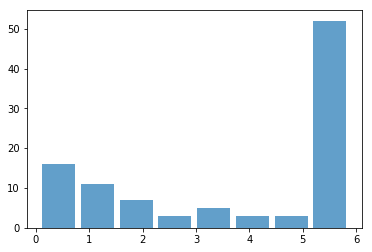

In [13]:
N1 = np.array(norms)
plt.hist(x=N1, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [14]:
scores = N1.transpose()[0]
arg_sorted = np.argsort(scores)

In [15]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [16]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean

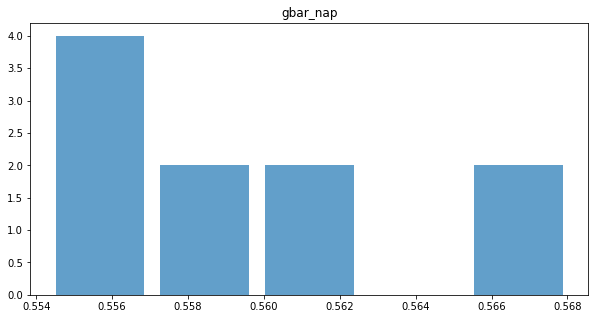

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

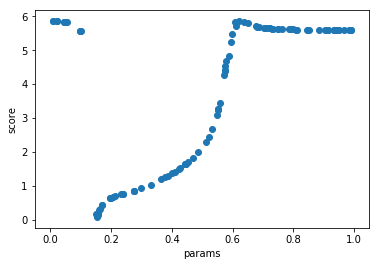

In [18]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

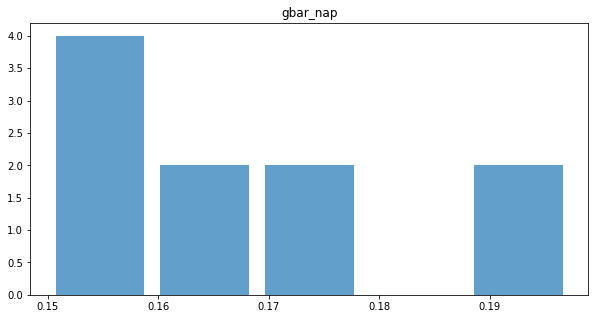

In [19]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

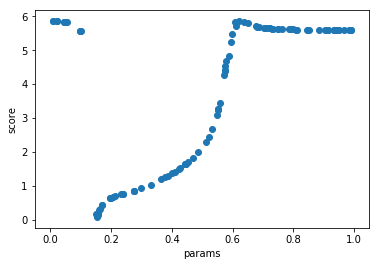

In [20]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

## Repeat for 1000 in a loop

In [21]:
n_samples = 1000
eps = 1

In [22]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [23]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 1000/1000 [12:01<00:00,  1.39it/s]


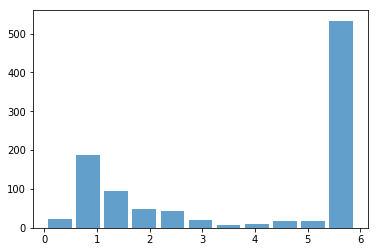

In [24]:
N5 = np.array(norms)
plt.hist(x=N5, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [25]:
scores = N5.transpose()[0]
arg_sorted = np.argsort(scores)

In [26]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [27]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean
# params_accept = params[arg_sorted[0:percent_criterion],:]
params_accept = params[arg_sorted[0:percent_criterion],:]*params_mean + params_std

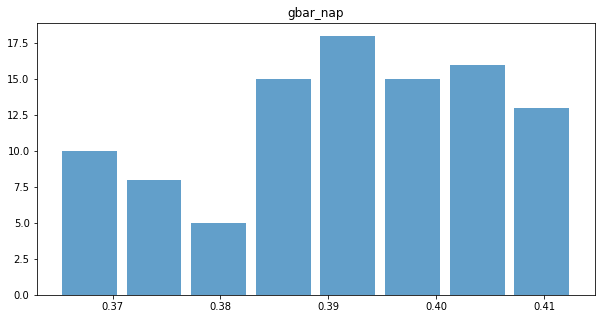

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

## Repeat for 2000 in a loop

In [29]:
n_samples = 2000
eps = 1

In [30]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [31]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 2000/2000 [22:17<00:00,  1.50it/s]


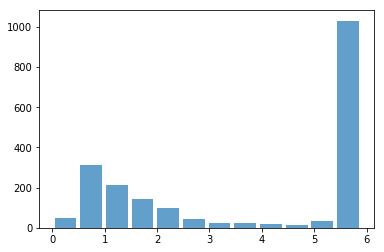

In [32]:
N5 = np.array(norms)
plt.hist(x=N5, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [33]:
scores = N5.transpose()[0]
arg_sorted = np.argsort(scores)

In [34]:
# rejection criterion
percent_accept = 2
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [35]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean
# params_accept = params[arg_sorted[0:percent_criterion],:]
params_accept = params[arg_sorted[0:percent_criterion],:]*params_mean + params_std

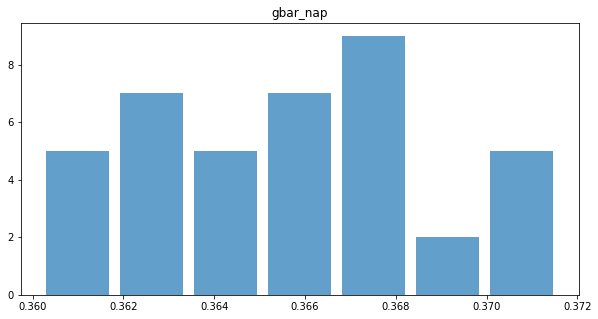

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

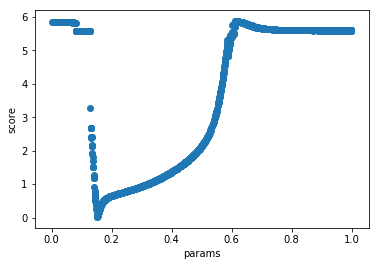

In [37]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

In [38]:
params

array([[0.99434835],
       [0.64890458],
       [0.07144252],
       ...,
       [0.75376896],
       [0.20161021],
       [0.67271696]])

In [39]:
scores

array([5.59874733, 5.78868154, 5.83708837, ..., 5.62269931, 0.65521319,
       5.71897561])

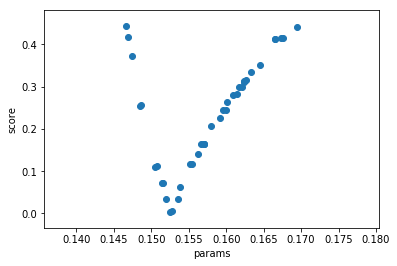

In [40]:
p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

plt.scatter(p, s)
plt.xlabel('params')
plt.ylabel('score');

In [41]:
p[0]

array([0.15245836])

In [42]:
dap_abc = DAPcython(-75, p[0])
U_abc = dap.simulate(dt, t, I)

No handles with labels found to put in legend.


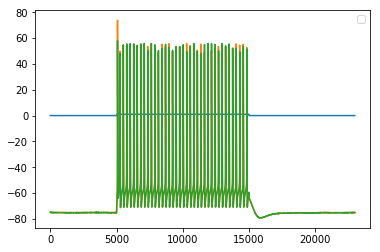

In [43]:
plt.plot(I)
plt.plot(U)
plt.plot(U_abc)
plt.legend();
